In [1]:
import os
from os.path import join
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib

## Step 2. 얼굴 검출 & 랜드마크 검출하기

In [2]:
def load_image(name): # 이미지 로드 함수
    image_dir = os.getenv('HOME')+'/development/Aiffel/Aiffel_Online5/Exploration3/images/'
    my_image_path = join(image_dir, name)
    img_bgr = cv2.imread(my_image_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_show = img_rgb.copy()

    return img_rgb, img_show

def show_image(image): # 이미지 표시 함수
    plt.imshow(image)
    plt.show()

_, img_s = load_image('jaemin2.jpeg')

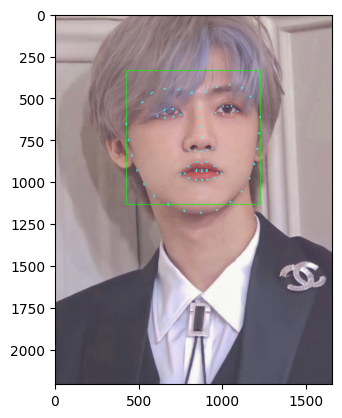

In [4]:
def detective_face(image):
    detector_hog = dlib.get_frontal_face_detector()
    dlib_rects = detector_hog(image, 1)
    
    for dlib_rect in dlib_rects:
        l = dlib_rect.left()
        t = dlib_rect.top()
        r = dlib_rect.right()
        b = dlib_rect.bottom()

        cv2.rectangle(image, (l,t),(r,b),(0,255,0),2, lineType=cv2.LINE_AA)

    model_path = os.getenv('HOME')+'/development/Aiffel/Aiffel_Online5/Exploration3/models/shape_predictor_68_face_landmarks.dat'
    landmark_predictor = dlib.shape_predictor(model_path)

    list_landmarks = []

    for dlib_rect in dlib_rects:
        points = landmark_predictor(image, dlib_rect)
        list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        list_landmarks.append(list_points)
    
    for landmark in list_landmarks:
        for point in landmark:
            cv2.circle(image, point, 3, (51,255,255), 2)

    #show_image(image)
    return dlib_rects, list_landmarks

detective_face(img_s)
show_image(img_s)

## Step 3. 스티커 적용 위치 확인하기

In [5]:
def load_sticker(name):
    sticker_dir = os.getenv('HOME')+'/development/Aiffel/Aiffel_Online5/Exploration3/images/'
    sticker_path = join(sticker_dir, name)
    img_sticker = cv2.imread(sticker_path)

    return img_sticker

In [6]:
def set_sticker(sticker, dlib_rects, list_landmarks):
    for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
        x = landmark[30][0]
        y = landmark[30][1] + 8
        w = h = dlib_rect.width()

    img_sticker = cv2.resize(sticker, (w,h))

    refined_x = (x - w // 2)
    refined_y = y - h // 2
        
    return refined_x, refined_y, img_sticker

## Step 4. 스티커 적용하기

In [28]:
def sticker(image,image_org, sticker):

    dlib_rects, list_landmark = detective_face(image)
    my_sticker = load_sticker(sticker)
    refined_x, refined_y, img_sticker = set_sticker(my_sticker, dlib_rects, list_landmark)

    sticker_area = image_org[refined_y:refined_y+img_sticker.shape[0], \
                    refined_x:refined_x+img_sticker.shape[1]]
    
    image_org[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    cv2.addWeighted(sticker_area, 0.5, np.where(img_sticker==255, sticker_area, img_sticker).astype(np.uint8), 0.5, 0)
    

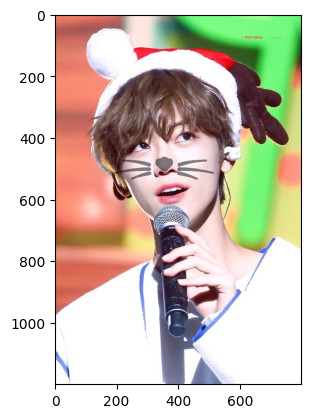

In [21]:
img_rgb, img_show = load_image('jaemin3.jpg')
sticker(img_show, img_rgb, 'cat.png')
show_image(img_rgb)

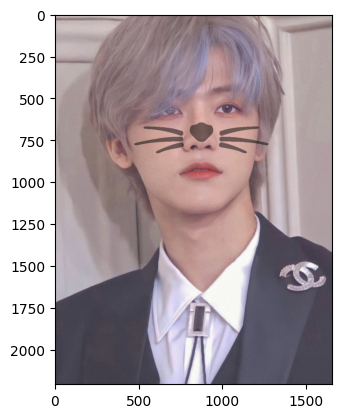

In [23]:
img_rgb, img_show = load_image('jaemin2.jpeg')
sticker(img_show, img_rgb, 'cat.png')
show_image(img_rgb)

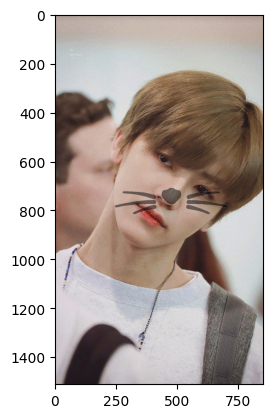

In [20]:
img_rgb, img_show = load_image('jaemin1.jpeg')
sticker(img_show, img_rgb, 'cat.png')
show_image(img_rgb)

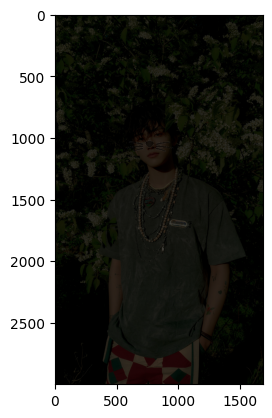

In [32]:
img_rgb, img_show = load_image('jaemindark.jpeg')
sticker(img_show, img_rgb, 'cat.png')
show_image(img_rgb)

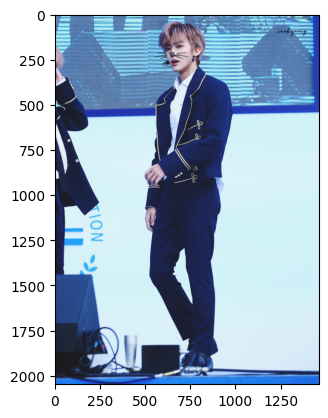

In [31]:
img_rgb, img_show = load_image('jaeminfar.jpeg')
sticker(img_show, img_rgb, 'cat.png')
show_image(img_rgb)

## 문제점 찾아보기

- 얼굴 각도가 달라져도 스티커는 얼굴에 맞춰 적용되지 않는다
    - 코 중심을 기준으로 양쪽 점끼리의 y좌표를 이용해 각도를 구한 후 스티커를 회전시키기
- 어두운 이미지는 인식했다
    - Hog 방식 특성상, 일부러 어둡게 만들었기 때문에 단순히 모든 픽셀값에서 동일한 값을 빼는 것과 같아서 픽셀간 변화량에는 영향을 미치지 않기 때문에 작동한다고 한다.
- 먼 이미지도 인식했다... 더 

In [22]:
import math

def rotate_sticker(sticker, list_landmarks):
    for landmark in list_landmarks:
        tan_theta = (landmark[30][0]-landmark[27][0])/(landmark[30][1] - landmark[27][1])
        theta = np.arctan(tan_theta)
        rotate_angle = theta * 180/math.pi
    
    sticker_center = tuple(np.array(sticker.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(sticker_center, rotate_angle, 1.0)
    result = cv2.warpAffine(sticker, rot_mat, sticker.shape[1::-1], flags = cv2.INTER_LINEAR, borderValue=(255,255,255))

    return result

In [23]:
def sticker(image,image_org, sticker):

    dlib_rects, list_landmarks = detective_face(image)
    my_sticker = load_sticker(sticker)
    refined_x, refined_y, img_sticker = set_sticker(my_sticker, dlib_rects, list_landmarks)
    rotated_sticker = rotate_sticker(img_sticker, list_landmarks)

    sticker_area = image_org[refined_y:refined_y+rotated_sticker.shape[0], \
                    refined_x:refined_x+rotated_sticker.shape[1]]
    
    image_org[refined_y:refined_y+rotated_sticker.shape[0], refined_x:refined_x+rotated_sticker.shape[1]] = \
    cv2.addWeighted(sticker_area, 0.5, np.where(rotated_sticker==255, sticker_area, rotated_sticker).astype(np.uint8), 0.5, 0)

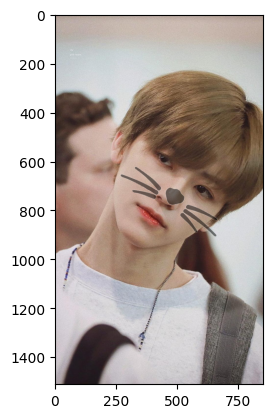

In [24]:
img_rgb, img_show = load_image('jaemin1.jpeg')
sticker(img_show, img_rgb, 'cat.png')
show_image(img_rgb)

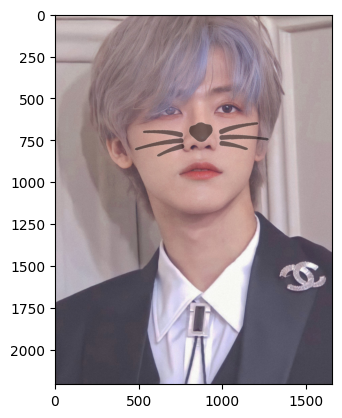

In [25]:
img_rgb, img_show = load_image('jaemin2.jpeg')
sticker(img_show, img_rgb, 'cat.png')
show_image(img_rgb)

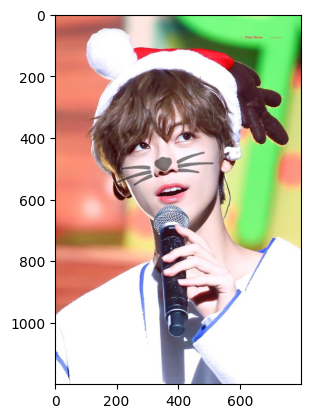

In [27]:
img_rgb, img_show = load_image('jaemin3.jpg')
sticker(img_show, img_rgb, 'cat.png')
show_image(img_rgb)